# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Импорт библиотек, загрузка данных и первичный анализ

Для начала импортируем все необходимые библиотеки 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

Сохраним данные в переменную **data**

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

в данных достаточно много пропусков. Тип данных некоторых столбцов не соответствует содержимому

In [4]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В данных так же присутствуют аномальные значения такие как:
- Цена автомобиля 0 евро
- Год регистрации автомобиля 1000 и 9999
- Мощность (в л.с.) 0 и 20000

### Пропуски и выбросы 

In [5]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Достаточно много пропусков в колонках которые содержат важные данные для определения стоимости автомобиля

Перед тем как решить что делать с пропусками нужно избавиться от бесполезных для предсказания стоимости авто признаков

Для этого проверим корреляцию в данных между числовыми значениями и целевым признаком 

In [6]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


Очень странным кажется низкая корреляция между целевым признаком **Price** и годом регистрации  **RegistrationYear**. Год автомобиля должен влиять на его конечную стоимость. Оставим эту колонку.

Удалим колонки:
- DateCreated (дата создания анкеты)
- DateCrawled (дата скачивания анкеты из базы)
- NumberOfPictures (количество фотографий автомобиля)
- PostalCode (почтовый индекс владельца анкеты)
- LastSeen (дата последней активности пользователя)
- RegistrationMonth (месяц регистрации автомобиля)

Эти признаки никак не помогут предсказать стоимость автомобиля

In [7]:
data = data.drop(['DateCreated', 'DateCrawled', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationMonth'], axis=1)

Так же избавимся от аномальных значений выявленных при первичном анализе

Возьмем порог минимальной стоимости автомобиля в 50 евро.

Мощность от 5 до 500 л.с.

Год регистрации (исходя из колонки LastSeen, которая не привышает 2016 год) возьмем от 1910 до 2017

In [8]:
data = data[data['Price'] > 50]
data = data[data['Power'] > 5]
data = data[data['Power'] < 500]
data = data[data['RegistrationYear'] < 2018]
data = data[data['RegistrationYear'] > 1910]

 Посмотрим на распределение данных в этих столбцах после очистки от аномальных значений

<AxesSubplot:xlabel='Price', ylabel='Count'>

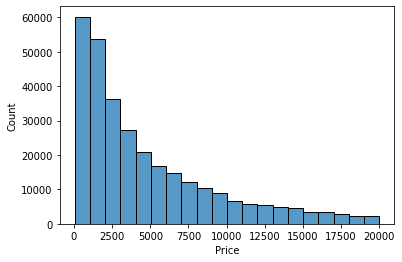

In [9]:
sns.histplot(data=data['Price'], bins=20)

<AxesSubplot:xlabel='Power', ylabel='Count'>

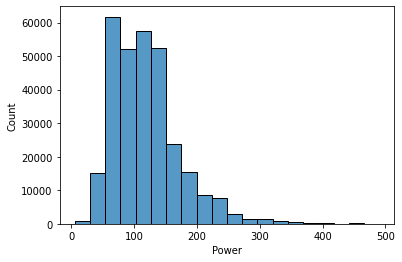

In [10]:
sns.histplot(data=data['Power'], bins=20)

<AxesSubplot:xlabel='RegistrationYear', ylabel='Count'>

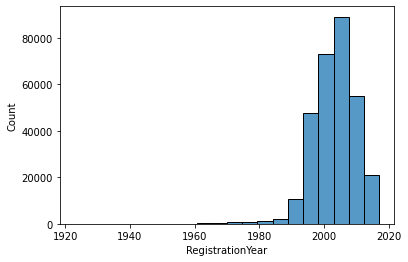

In [11]:
sns.histplot(data=data['RegistrationYear'], bins=20)

Распределение кажется адекватным. Те редкие значения по году регистрации могут быть раритетные старые автомобили, а мощность до 500 л.с. редкие авто с мощными двигателями.

Взглянем на пропуски еще раз

In [12]:
data.isna().sum()

Price                   0
VehicleType         18186
RegistrationYear        0
Gearbox              5765
Power                   0
Model               11829
Kilometer               0
FuelType            18282
Brand                   0
Repaired            45576
dtype: int64

Не представляется возможным восстановить данные по модели автомобиля. Удалим пропуски в этом столбце

In [13]:
data = data.dropna(subset=['Model']).reset_index(drop=True)

In [14]:
data.isna().sum()

Price                   0
VehicleType         15763
RegistrationYear        0
Gearbox              5026
Power                   0
Model                   0
Kilometer               0
FuelType            15186
Brand                   0
Repaired            41548
dtype: int64

Пропуски в колонках **'Gearbox'**, **'VehicleType'** и **'FuelType'** можно заполнить самым популярным значением по Модели автомобиля

In [15]:
data['Gearbox'] = data.groupby('Model')['Gearbox'].transform(lambda x: x.fillna(x.mode()[0]))
data['VehicleType'] = data.groupby('Model')['VehicleType'].transform(lambda x: x.fillna(x.mode()[0]))
data['FuelType'] = data.groupby('Model')['FuelType'].transform(lambda x: x.fillna(x.mode()[0]))

Пропуски в столбце **'Repaired'** можно заполнить как **'unknown'** т.к. нельзя узнать из имеющихся данных была ли машина в ремонте или нет

In [16]:
data['Repaired'] = data['Repaired'].fillna('unknown')

In [17]:
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

Пропуски заполнены сохраним данные в переменную **final_data**

In [18]:
final_data = data
final_data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
1,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
2,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
3,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
4,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
...,...,...,...,...,...,...,...,...,...,...
290896,5250,wagon,2016,auto,150,159,150000,gasoline,alfa_romeo,no
290897,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
290898,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
290899,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


### Разделение на выборки

Разделим данные на признаки и целевой признак 

In [19]:
features = final_data.drop(['Price'], axis=1)
target = final_data['Price']

Создадим обучающую, валидационную и тестовую выборки в соотношении 3:1:1

In [20]:
train_features, valid_features, train_target, valid_target = train_test_split(
    features, target, test_size=0.40, random_state=333)

In [21]:
valid_features, test_features, valid_target, test_target = train_test_split(valid_features, valid_target,
                                                                            test_size=0.50, random_state=333)

In [22]:
print(train_features.shape, train_target.shape)
print(valid_features.shape, valid_target.shape)
print(test_features.shape, test_target.shape)

(174540, 9) (174540,)
(58180, 9) (58180,)
(58181, 9) (58181,)


### Кодировка и масштабирование

Признак **'Model'** содержит в себе большое количество категорий. Соответственно если кодировать данные по технике **OHE**, то у нас появится очень много новых колонок. Лучше будет применить в данном случае **OrdinalEncoder**

In [23]:
encoder = OrdinalEncoder()

cat_columns = ['Model', 'VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'Brand']

features_train_ord = train_features.copy()
features_valid_ord = valid_features.copy()
features_test_ord = test_features.copy()

features_train_ord[cat_columns] = encoder.fit_transform(features_train_ord[cat_columns])
features_valid_ord[cat_columns] = encoder.fit_transform(features_valid_ord[cat_columns])
features_test_ord[cat_columns] = encoder.fit_transform(features_test_ord[cat_columns])

С помощью **StandardScaler** проведем масштабирование признаков

In [24]:
scaler = StandardScaler()

col_for_scale = ['RegistrationYear', 'Power', 'Kilometer']

In [25]:
train_features_scale = features_train_ord
valid_features_scale = features_valid_ord
test_features_scale = features_test_ord

train_features_scale[col_for_scale] = scaler.fit_transform(train_features_scale[col_for_scale])
valid_features_scale[col_for_scale] = scaler.fit_transform(valid_features_scale[col_for_scale])
test_features_scale[col_for_scale] = scaler.fit_transform(test_features_scale[col_for_scale])

# Вывод
Во время подготовки данных:
- избавились от аномальных значений
- избавились от пропусков в данных
- сохранили только необходимые для предсказания стоимости автомобиля признаки
- произвели масштабирование и кодировку категориальных признаков  

Данные готовы. Можно переходить к обучению 

## Обучение моделей

### CatBoost

In [26]:
cat_boost_model = CatBoostRegressor(loss_function='RMSE', iterations=150, learning_rate=0.3)

обучение модели

In [27]:
%%time
cat_boost_model.fit(train_features_scale, train_target, verbose=20)

0:	learn: 3761.8283986	total: 83.5ms	remaining: 12.4s
20:	learn: 1860.4749635	total: 556ms	remaining: 3.41s
40:	learn: 1757.7479886	total: 1.03s	remaining: 2.73s
60:	learn: 1702.5317804	total: 1.47s	remaining: 2.15s
80:	learn: 1666.7579089	total: 1.93s	remaining: 1.64s
100:	learn: 1641.5996703	total: 2.39s	remaining: 1.16s
120:	learn: 1619.7682449	total: 2.86s	remaining: 686ms
140:	learn: 1605.6449387	total: 3.39s	remaining: 216ms
149:	learn: 1599.0006093	total: 3.63s	remaining: 0us
CPU times: user 3.64 s, sys: 54.3 ms, total: 3.69 s
Wall time: 4.54 s


предсказание

In [28]:
%%time
cat_boost_pred = cat_boost_model.predict(valid_features_scale)

CPU times: user 19.2 ms, sys: 315 µs, total: 19.6 ms
Wall time: 17.3 ms


RMSE

In [29]:
mean_squared_error(valid_target, cat_boost_pred, squared=False)

1714.698775651066

**CatBoostRegressor**:
- время обучения - **3 - 4 секунд**
- время предсказания - **менее секунды**
- RMSE - **1714**

### Линейная регрессия

In [30]:
l_r_model = LinearRegression()

In [31]:
%%time
l_r_model.fit(train_features_scale, train_target)

CPU times: user 44.7 ms, sys: 12.1 ms, total: 56.8 ms
Wall time: 46.8 ms


LinearRegression()

In [32]:
%%time
l_r_pred = l_r_model.predict(valid_features_scale)

CPU times: user 22 ms, sys: 40.2 ms, total: 62.1 ms
Wall time: 19.9 ms


In [33]:
mean_squared_error(valid_target, l_r_pred, squared=False)

2920.498773759134

**LinearRegression**:
- время обучения - **менее секунды**
- время предсказания - **менее секунды**
- RMSE - **2920**

### Случайный лес

In [34]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

param_grid = { 
    'n_estimators': [35, 40, 45],
    'max_depth' : [8, 9, 10]
}

Подбор гиперпараметров с помощью GridSearchCV

In [35]:
r_forest_model = RandomForestRegressor(random_state=333)


grid_r = GridSearchCV(r_forest_model, param_grid, scoring=scorer, cv=3)
grid_r.fit(train_features_scale, train_target)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=333),
             param_grid={'max_depth': [8, 9, 10], 'n_estimators': [35, 40, 45]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

Выбор лучшей модели

In [36]:
r_forest_model = grid_r.best_estimator_
r_forest_model

RandomForestRegressor(max_depth=10, n_estimators=40, random_state=333)

In [37]:
r_forest_model = RandomForestRegressor(max_depth=10, n_estimators=40, random_state=333)

In [38]:
%%time
r_forest_model.fit(train_features_scale, train_target)

CPU times: user 8.7 s, sys: 7.95 ms, total: 8.71 s
Wall time: 8.74 s


RandomForestRegressor(max_depth=10, n_estimators=40, random_state=333)

In [39]:
%%time
r_forest_model_pred = r_forest_model.predict(valid_features_scale)

CPU times: user 207 ms, sys: 0 ns, total: 207 ms
Wall time: 208 ms


In [40]:
mean_squared_error(valid_target, r_forest_model_pred, squared=False)

1877.9066390557316

**RandomForestRegressor**:
- время обучения - **9-10 секунд** (без учета подбора параметров с помощью GridSearchCV)
- время предсказания - **менее секунды**
- RMSE - **1877**

### LightGBM

In [41]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.3,
    'feature_fraction': 0.9
}

In [42]:
%%time
train_data = lgb.Dataset(train_features_scale, label=train_target)
model = lgb.train(params, train_data, num_boost_round=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.345525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Number of data points in the train set: 174540, number of used features: 9
[LightGBM] [Info] Start training from score 4880.758961
CPU times: user 5min 44s, sys: 5.27 s, total: 5min 49s
Wall time: 5min 51s


In [43]:
%%time
lgb_pred = model.predict(valid_features_scale)

CPU times: user 369 ms, sys: 2.92 ms, total: 372 ms
Wall time: 384 ms


In [44]:
mean_squared_error(valid_target, lgb_pred, squared=False)

1674.4837456679297

**LightGBM**:
- время обучения - **2 минуты**
- время предсказания - **менее секунды**
- RMSE - **1674**

## Анализ моделей

Были обучены 4 модели. Скорость предсказания каждой модели была менее одной секунды. Данный критерий не будет участвовать в анализе. Возьмем время обучения и RMSE на валидационной выборке.

RMSE моделей:
- CatBoost - 1714
- LinearRegression - 2920
- RandomForestRegressor - 1877
- **LightGBM - 1674**

Время обучения:
- CatBoost - 3-4 секунды
- **LinearRegression - менее секунды**
- RandomForestRegressor - 9-10 секунд (без учета времени на подбор гиперпараметров)
- LightGBM - 2 минуты

In [45]:
index = ['CatBoost', 'LinearRegression', 'RandomForestRegressor', 'LightGBM']

test_info = {'Время обучения в секундах': ['3-4', '< 1', '9-10', '150'], 
             'Время предсказания в секундах': ['< 1', '< 1', '< 1', '< 1'],
            'RMSE': [1714, 2920, 1877, 1674]}

df = pd.DataFrame(test_info, index=index)
df

,Время обучения в секундах,Время предсказания в секундах,RMSE
CatBoost,3-4,< 1,1714
LinearRegression,< 1,< 1,2920
RandomForestRegressor,9-10,< 1,1877
LightGBM,150,< 1,1674


Самая быстрая по обучению модель (очевидно) - линейная регрессия, но и качество предсказаний значительно хуже. Алгоритм случайного леса занимает 3 место по RMSE и по скорости. Эти две модели можно отбросить.

RMSE метрика LightGBM не сильно лучше чем у CatBoost, но по скорости обучения LightGBM значительно уступает CatBoost

По итогам анализа лучшей моделью по всем критериям (качество предсказания, время обучения, время предсказания) является - **CatBoost** со временем обучения в **3-4 секунды** и RMSE на валидационной выборке - **1714**

## Тестирование лучшей модели

Лучшей моделью по основным критериям стала модель CatBoostRegressor. Проверим качество модели на тестовой выборке

In [46]:
prediction = cat_boost_model.predict(test_features_scale)

rmse = mean_squared_error(test_target, prediction, squared=False)

print('RMSE лучшей модели на тестовой выборке составило: ', int(rmse))

RMSE лучшей модели на тестовой выборке составило:  1693


Сравним со статичной моделью 

In [47]:
dummy_pred = pd.Series(valid_target.mean(), index=valid_target.index)
print('RMSE статичной модели: ')
mean_squared_error(valid_target, dummy_pred, squared=False)

RMSE статичной модели: 


4593.611162673728

# Итоговый вывод:

**1. Подготовка данных**

Во время работы с данными:
- избавились от выбросов 
- избавились от лишних признаков
- избавились от пропусков
- провели кодировку категориальных признаков 
- провели масштабирование признаков

**2. Обучение моделей**

- обучили 4 модели
- подобрали гиперпараметры к ним
- замерили время выполнения ячеек 
- сохранили качество предсказаний по метрике RMSE

**3. Анализ моделей**

- проанализированы результаты всех моделей 
- выбрана оптимальная, по всем критериям качества, модель
- сравнили модель со статичной

Оптимальной по всем критериям оказалась модель **CatBoost** с результатами:
- время обучения - **3 - 4 секунд**
- время предсказания - **менее секунды**
- RMSE - **1714**
- RMSE на итоговом тестировании - **1693**